<a href="https://colab.research.google.com/github/aherre52/MAT422/blob/main/MAT_422_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Will import the relevant packages

import kagglehub # get the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import zipfile
import os


In [ ]:
# import data

# Download latest version, using link from kaggle website
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

# now just get the dataset
for file in os.listdir(path):
    if file.endswith('.csv'):  # find the CSV file
        PIDD_file = os.path.join(path, file)
        break

# Load the dataset into a dataFrame
df = pd.read_csv(PIDD_file)

# Display the first few rows, check data was imported as expected
df.head(5)

100%|██████████| 8.91k/8.91k [00:00<00:00, 8.60MB/s]

Extracting files...


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# adjust the code for cleaning. if glucose, blood press, skin thickness, insulin, BMI, pedigree fn or age is 0, make it NaN

columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

# Replace 0 with NaN in the specified columns
df[columns_to_replace] = df[columns_to_replace].replace(0, np.nan)

# Verify the changes
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


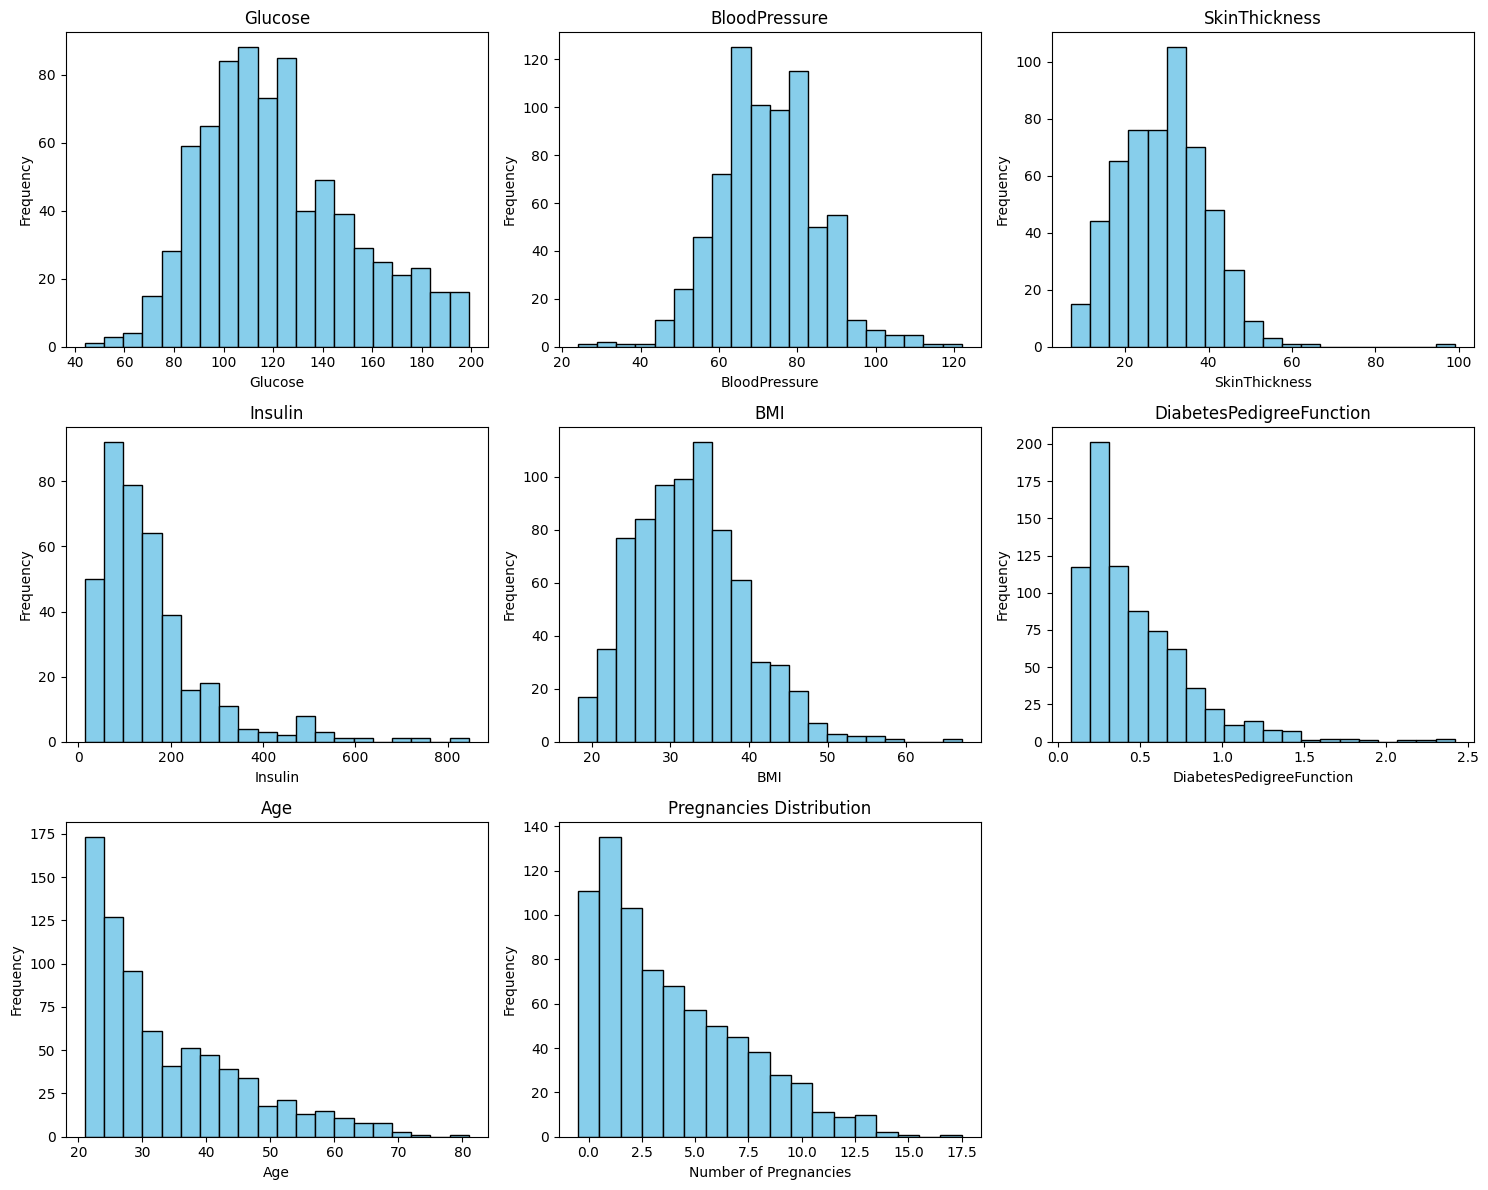

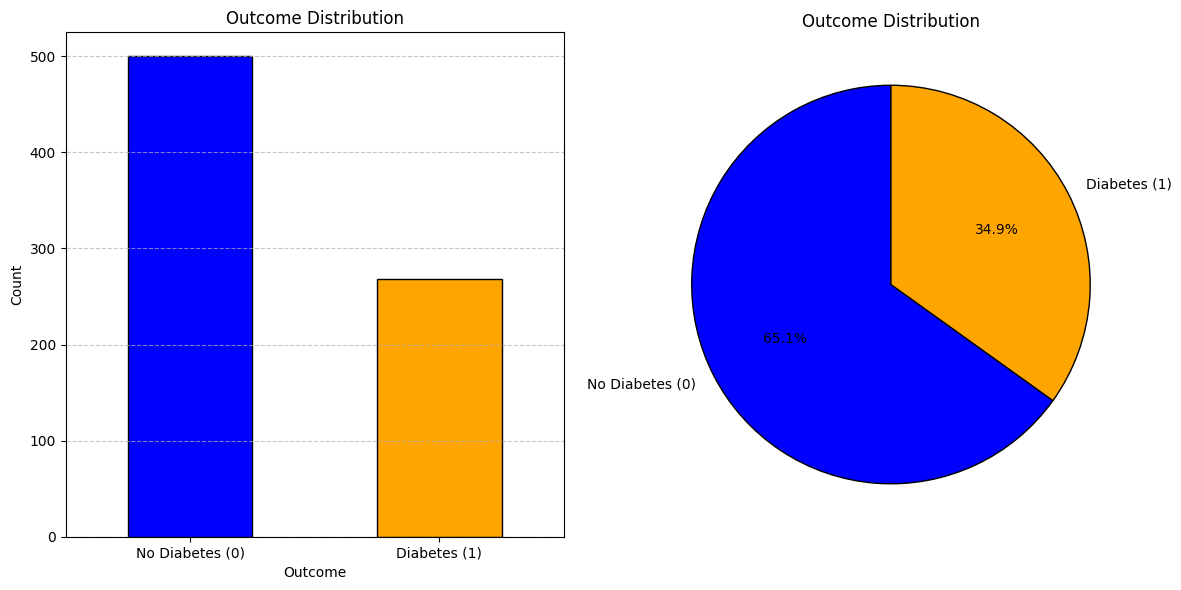

In [ ]:
# create a separate bar chart for outcome
outcome_counts = df['Outcome'].value_counts()

# Plot histograms for other columns
num_columns = len(df.columns) - 1  # Exclude Outcome
rows = (num_columns + 2) // 3  # Number of rows for subplots
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column except Outcome and pregnancies, want those separate
columns_to_plot = [col for col in df.columns if col != 'Outcome' and col != 'Pregnancies']

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    df[column].dropna().hist(ax=ax, bins=20,color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(False)

# Plot "Pregnancies" column in the next available subplot
ax = axes[i + 1]  # move to the next axis after the last plotted histogram
df['Pregnancies'].dropna().hist(ax=ax, bins=np.arange(df['Pregnancies'].min(), df['Pregnancies'].max() + 2) - 0.5, color='skyblue', edgecolor='black')
ax.set_title('Pregnancies Distribution')
ax.set_xlabel('Number of Pregnancies')
ax.set_ylabel('Frequency')
ax.grid(False)  # Disable gridlines or mesh overlay

# Remove empty subplots
for j in range(i + 2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Plot Outcome charts separately
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Outcome histogram on the first axis
outcome_counts.plot(kind='bar', ax=axes[0], color=['blue', 'orange'], edgecolor='black')
axes[0].set_title('Outcome Distribution')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'], rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the Outcome pie chart on the second axis
outcome_counts.plot.pie(
    labels=['No Diabetes (0)', 'Diabetes (1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['blue', 'orange'],
    wedgeprops={'edgecolor': 'black'},
    ax=axes[1]
)
axes[1].set_title('Outcome Distribution')
axes[1].set_ylabel('')  # Remove default y-label for pie chart

plt.tight_layout()
plt.show()


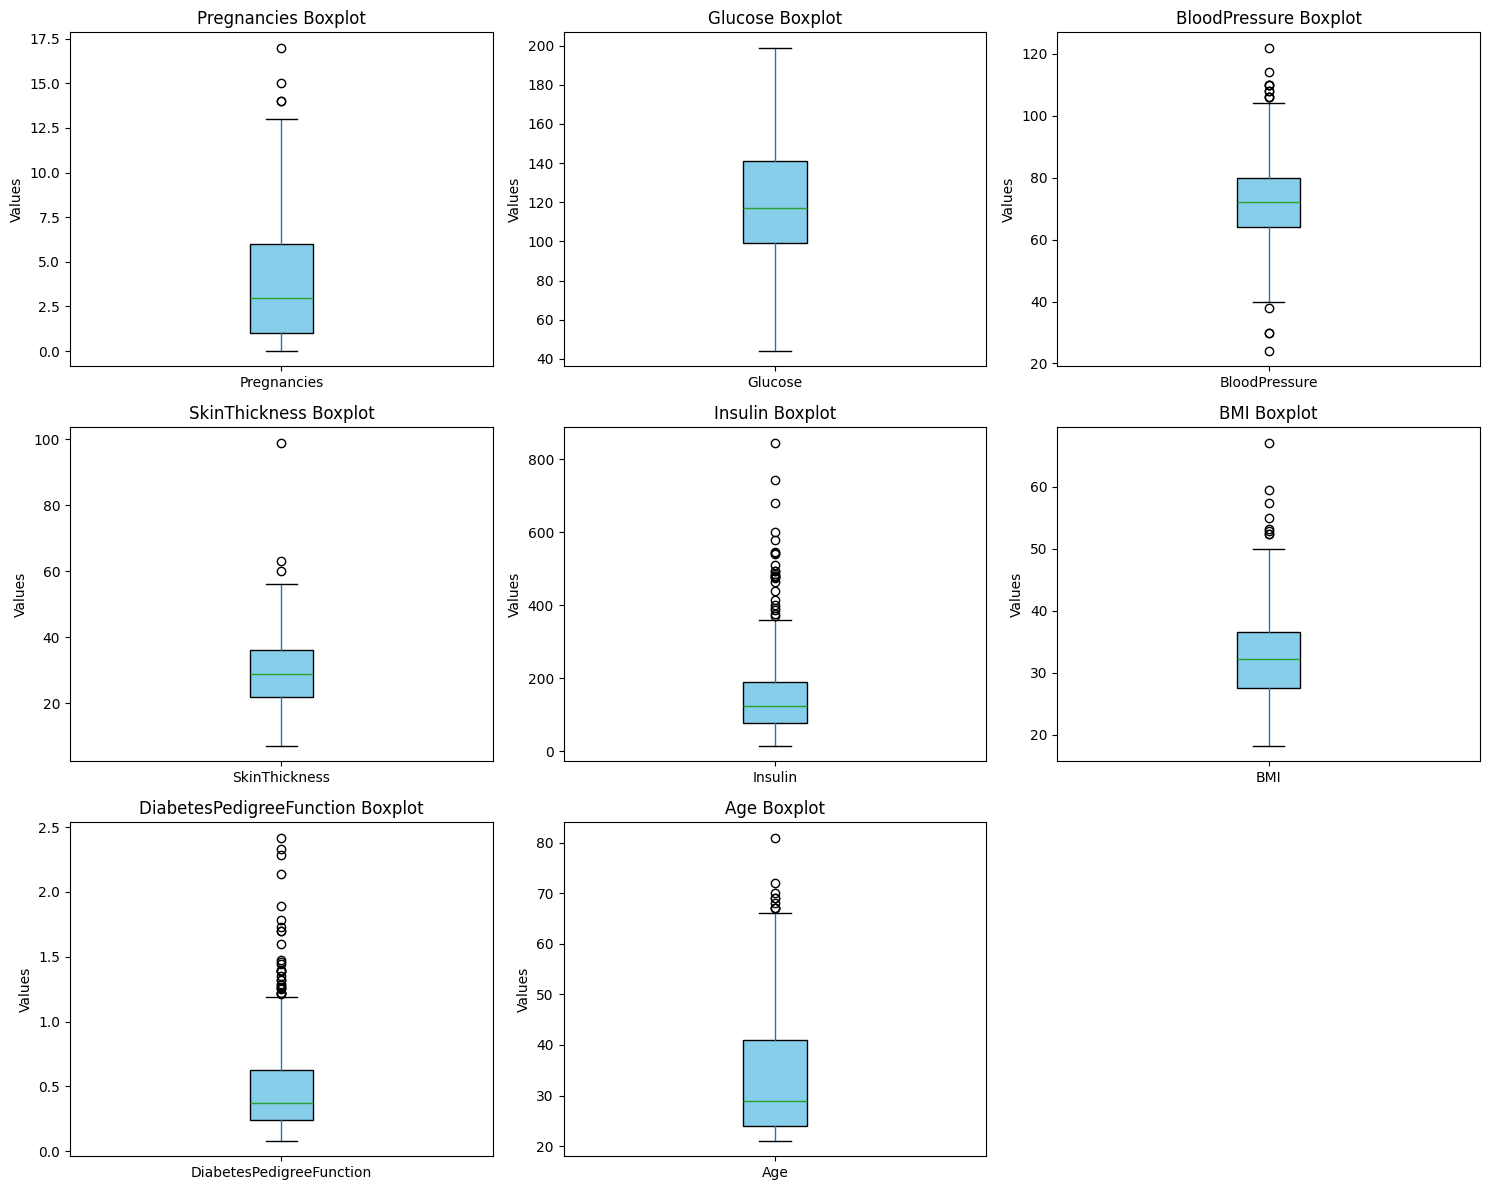

In [ ]:
# will provide more visuals for understanding the data provided

# Columns to plot (excluding 'Outcome')
columns_to_plot = [col for col in df.columns if col != 'Outcome']

# Number of columns to plot
num_columns = len(columns_to_plot)
rows = (num_columns + 2) // 3  # Adjust rows for grid layout

# Create subplots for boxplots
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    df.boxplot(column=column, ax=ax, grid=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    ax.set_title(f'{column} Boxplot')
    ax.set_ylabel('Values')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Will split the data using 80/20



In [ ]:
# use above imported library to split data

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Outcome'])

# Preprocess the Data#

Will now begin to preprocess the data to create the logistic regression model. Based off of the boxplots, will impute the missing values as follows:
* do mean for attributes without many outliers (only glucose),
* otherwise use median for attributes with outliers.

In [ ]:
# will now preprocess the training set
train_df_processed = train_df.copy()

# Impute missing values in the training set
for column in train_df_processed.columns:
    if column != 'Glucose':
        train_df_processed[column] = train_df_processed[column].fillna(train_df_processed[column].median())  # Impute with median

train_df_processed['Glucose'] = train_df_processed['Glucose'].fillna(train_df_processed['Glucose'].mean())  # Impute 'Glucose' with mean


# with the TRAINING set, now preprocess the test set using the training sets parameters
test_df_processed = test_df.copy()

# Impute missing values in the test set using training set parameters
for column in test_df_processed.columns:
    if column != 'Glucose':
        test_df_processed[column] = test_df_processed[column].fillna(train_df_processed[column].median())  # Use training median

test_df_processed['Glucose'] = test_df_processed['Glucose'].fillna(train_df_processed['Glucose'].mean())  # Use training mean


Next will deal with outliers using IQR-based filtering. Will remove values outside 1.5x IQR from the IQR range.

In [ ]:
for column in train_df_processed.columns:
    if column != 'Outcome':  # Skip the target column
        Q1 = train_df_processed[column].quantile(0.25)
        Q3 = train_df_processed[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train_df_processed[column] = train_df_processed[column].clip(lower_bound, upper_bound)

for column in test_df_processed.columns:
    if column != 'Outcome':  # Skip the target column
        Q1 = train_df_processed[column].quantile(0.25)
        Q3 = train_df_processed[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        test_df_processed[column] = test_df_processed[column].clip(lower_bound, upper_bound)



Just to check, will reuse code from above for boxplots to see how outliers look like now

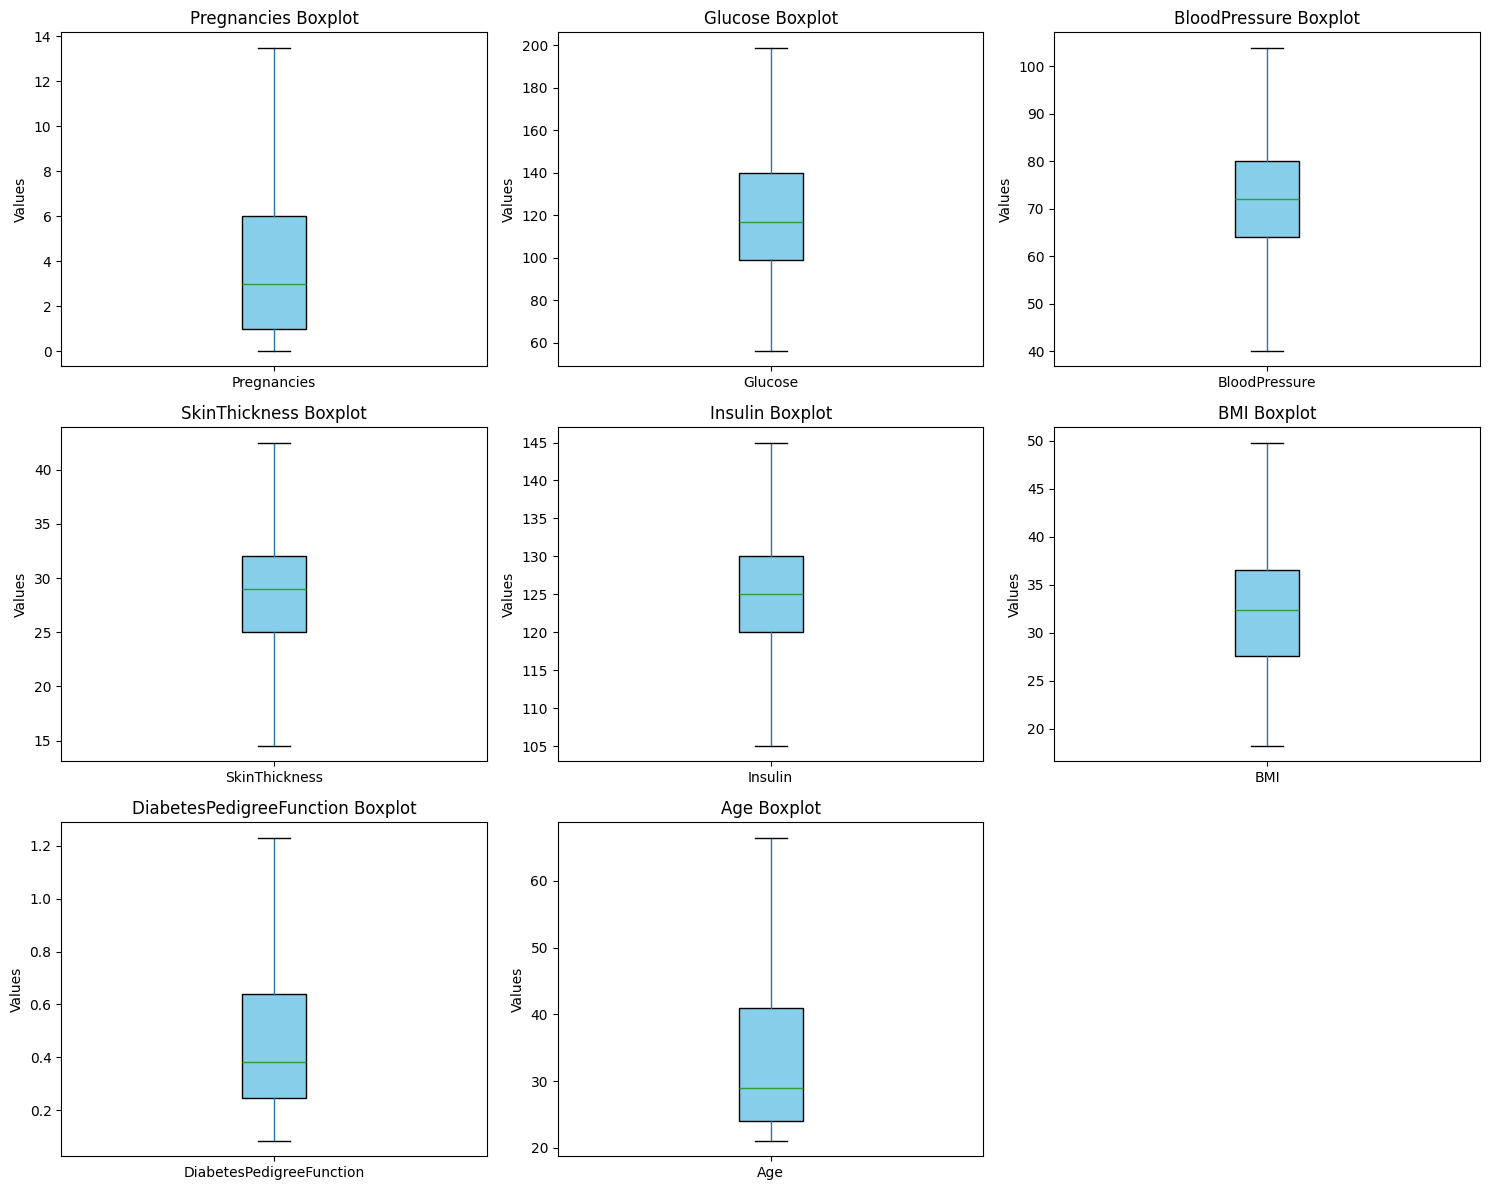

In [ ]:
# will provide more visuals for understanding the data provided

# Columns to plot (excluding 'Outcome')
columns_to_plot = [col for col in train_df_processed.columns if col != 'Outcome']

# Number of columns to plot
num_columns = len(columns_to_plot)
rows = (num_columns + 2) // 3  # Adjust rows for grid layout

# Create subplots for boxplots
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    train_df_processed.boxplot(column=column, ax=ax, grid=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    ax.set_title(f'{column} Boxplot')
    ax.set_ylabel('Values')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


check for multicollinearity


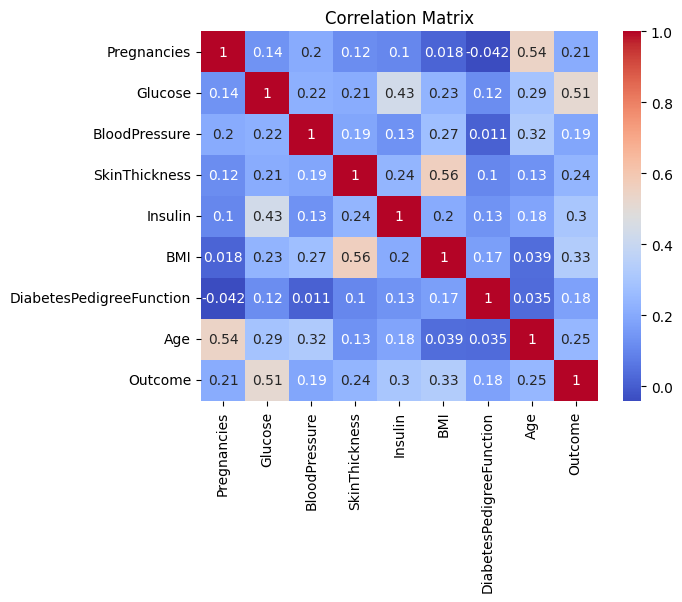

In [ ]:
corr_matrix = train_df_processed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:

# Select the features except for 'Outcome'
X = train_df_processed.drop(columns=['Outcome'])

# Add a constant (intercept) to the model for VIF calculation
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display the results
print(vif_data)


                    feature         VIF
0                     const  116.188812
1               Pregnancies    1.433076
2                   Glucose    1.353635
3             BloodPressure    1.223483
4             SkinThickness    1.521825
5                   Insulin    1.277532
6                       BMI    1.606210
7  DiabetesPedigreeFunction    1.050146
8                       Age    1.619512


# Proceed to scale the data
Make sure to only run the cell ONCE, do NOT fit again

In [ ]:
# can initialize the scaler from package declared above
scaler = StandardScaler()

# will fit the scaler to the training data (dont want to leak test data) and transform the training data
train_df_scaled = train_df_processed.copy()
train_df_scaled[train_df_scaled.columns.difference(['Outcome'])] = scaler.fit_transform(train_df_scaled[train_df_scaled.columns.difference(['Outcome'])])

# will also transform the test data using the same scaler
test_df_scaled = test_df_processed.copy()
test_df_scaled[test_df_scaled.columns.difference(['Outcome'])] = scaler.transform(test_df_scaled[test_df_scaled.columns.difference(['Outcome'])])


In [ ]:
# Display the scaled data
train_df_scaled.head()
#test_df_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
353,-0.855120,-1.057533,-0.858066,-1.910489,-1.473258,-0.785079,0.393103,-0.798419,0
711,0.360963,0.143389,0.500239,-0.243007,-1.473258,-0.421652,-0.093401,0.572372,0
373,-0.551100,-0.557149,-1.197642,1.491175,-1.473258,0.380916,-0.831784,-0.712745,0
46,-0.855120,0.810568,-1.367431,0.023790,0.006507,-0.406509,0.337897,-0.370047,0
682,-1.159141,-0.890739,-0.688278,1.357776,-1.473258,1.849765,-0.345280,-0.969768,0


# Implement resampling techniques


*   Begin with Cross-Validation



In [ ]:
# Load the data from scaled data. will use this X and Y as parameters passed into functions
X = train_df_scaled.drop('Outcome', axis=1)
y = train_df_scaled['Outcome']

# Split into training (80%) and validation (20%) sets, this will be used for bootstrap
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

K-Fold Cross-Validation Results:
   Accuracy  Precision_0  Precision_1  Recall_0  Recall_1      F1_0      F1_1
0  0.774194     0.770833     0.785714     0.925  0.500000  0.840909  0.611111
1  0.790323     0.829268     0.714286     0.850  0.681818  0.839506  0.697674
2  0.822581     0.808511     0.866667     0.950  0.590909  0.873563  0.702703
3  0.725806     0.794872     0.608696     0.775  0.636364  0.784810  0.622222
4  0.819672     0.808511     0.857143     0.950  0.571429  0.873563  0.685714
5  0.819672     0.808511     0.857143     0.950  0.571429  0.873563  0.685714
6  0.770492     0.809524     0.684211     0.850  0.619048  0.829268  0.650000
7  0.786885     0.800000     0.750000     0.900  0.571429  0.847059  0.648649
8  0.819672     0.853659     0.750000     0.875  0.714286  0.864198  0.731707
9  0.737705     0.785714     0.631579     0.825  0.571429  0.804878  0.600000


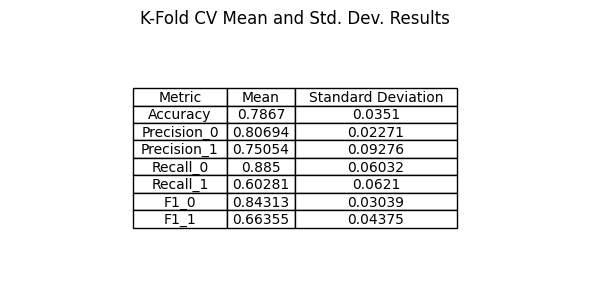

In [ ]:
# create logistic regression model
# originally allowed default (100) and 150 iters, but didnt converge. so chose 200
model = LogisticRegression(max_iter=200)

# create a function for K-Fold Cross-Validation
def k_fold_cross_validation(X, y, num_folds=10):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    cv_results = []

    # Perform cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model.fit(X_train, y_train)

        # Get predictions and classification report
        y_pred = model.predict(X_val)
        report = classification_report(y_val, y_pred, output_dict=True)

        # Store the results from the report for analysis
        accuracy = report['accuracy']
        precision_0 = report['0']['precision']
        precision_1 = report['1']['precision']
        recall_0 = report['0']['recall']
        recall_1 = report['1']['recall']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        cv_results.append({
            'Accuracy': accuracy,
            'Precision_0': precision_0,
            'Precision_1': precision_1,
            'Recall_0': recall_0,
            'Recall_1': recall_1,
            'F1_0': f1_0,
            'F1_1': f1_1
        })

    return pd.DataFrame(cv_results)

# Perform k-fold cross-validation
cv_results_df = k_fold_cross_validation(X, y, num_folds=10)

# Print the results
print("K-Fold Cross-Validation Results:")
print(cv_results_df)

# calculate and print mean and standard deviation for each metric
cv_means = cv_results_df.mean()
cv_std = cv_results_df.std()

# Combine mean and standard deviation into a DataFrame
results_summary = pd.DataFrame({
    'Metric': cv_means.index,
    'Mean': cv_means.round(5).values,
    'Standard Deviation': cv_std.round(5).values
})

# wanna display the mean and std dev in table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the plot
table = ax.table(
    cellText=results_summary.values,
    colLabels=results_summary.columns,
    cellLoc='center',
    loc='center'
)

# Format the table for better visibility
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column widths to reduce white space
table.auto_set_column_width(col=list(range(len(results_summary.columns))))

# Add a title above the table
plt.title("K-Fold CV Mean and Std. Dev. Results", fontsize=12, pad=10)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
print("\nK fold CV Mean and std dev Results:")
print(cv_means)
print(cv_std)


K fold CV Mean Results:
Accuracy       0.781835
Precision_0    0.802030
Precision_1    0.744926
Recall_0       0.885000
Recall_1       0.588961
F1_0           0.840293
F1_1           0.651790
dtype: float64
Accuracy       0.040243
Precision_0    0.031072
Precision_1    0.094970
Recall_0       0.060323
Recall_1       0.084987
F1_0           0.032489
F1_1           0.064065
dtype: float64


Next implement boot sampling

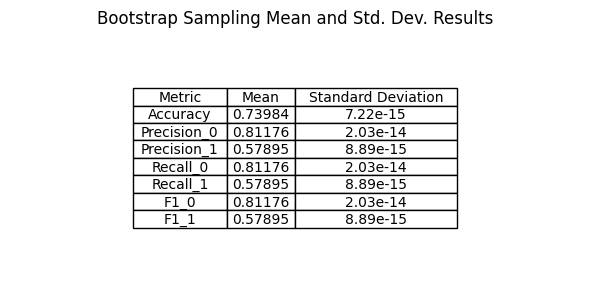

In [ ]:


def bootstrap_sampling(X_train, y_train, X_val, y_val, n_samples=1000):
    # Will store bootstrap results to analyze
    bootstrap_results = []

    # Initialize the model, use 200 again
    model = LogisticRegression(max_iter=200)

    # Will now perform bootstrap sampling
    for i in range(n_samples):
        # sample WITH replacement from the training data
        X_resampled, y_resampled = resample(X_train, y_train, random_state=42)

        # Train the model on the resampled data
        model.fit(X_resampled, y_resampled)

        # Evaluate the model
        y_pred = model.predict(X_val)

        # Generate the classification report again
        report = classification_report(y_val, y_pred, output_dict=True)

        # take the same metrics
        accuracy = report['accuracy']
        precision_0 = report['0']['precision']
        precision_1 = report['1']['precision']
        recall_0 = report['0']['recall']
        recall_1 = report['1']['recall']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        # Store results in the list
        bootstrap_results.append({
            'Sample': i,
            'Accuracy': accuracy,
            'Precision_0': precision_0,
            'Precision_1': precision_1,
            'Recall_0': recall_0,
            'Recall_1': recall_1,
            'F1_0': f1_0,
            'F1_1': f1_1
        })

    return pd.DataFrame(bootstrap_results)

# Perform Bootsrtrao, make function call
bootstrap_results_df = bootstrap_sampling(X_train, y_train, X_val, y_val, n_samples=1000)

# calculate and print mean and standard deviation for each metric
bs_means = bootstrap_results_df.mean()
bs_std = bootstrap_results_df.std()

# Combine mean and standard deviation into a DataFrame
results_summary = pd.DataFrame({
    'Metric': bs_means.index,
    'Mean': bs_means.round(5).values,
    'Standard Deviation': [format(x, '.3g') for x in bs_std.values]
})

# drop sample column
results_summary = results_summary[results_summary['Metric'] != 'Sample']

# wanna display the mean and std dev in table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the plot
table = ax.table(
    cellText=results_summary.values,
    colLabels=results_summary.columns,
    cellLoc='center',
    loc='center'
)

# Format the table for better visibility
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column widths to reduce white space
table.auto_set_column_width(col=list(range(len(results_summary.columns))))

# Add a title above the table
plt.title("Bootstrap Sampling Mean and Std. Dev. Results", fontsize=12, pad=10)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
print("\nBootsrap Mean and std dev Results:")
print(bs_means)
print(bs_std)


Bootsrap Mean and std dev Results:
Sample         499.500000
Accuracy         0.739837
Precision_0      0.811765
Precision_1      0.578947
Recall_0         0.811765
Recall_1         0.578947
F1_0             0.811765
F1_1             0.578947
dtype: float64
Sample         2.888194e+02
Accuracy       7.220061e-15
Precision_0    2.032725e-14
Precision_1    8.886228e-15
Recall_0       2.032725e-14
Recall_1       8.886228e-15
F1_0           2.032725e-14
F1_1           8.886228e-15
dtype: float64


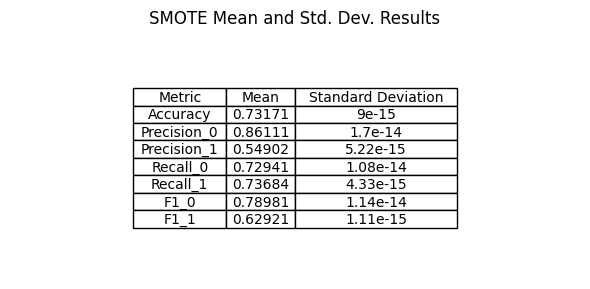

In [ ]:

def smote_resampling(X_train, y_train, X_val, y_val, n_samples=1000):
    # Will store SMOTE results to analyze just like bootstrap and cross validation
    smote_results = []

    # Initialize the model
    model = LogisticRegression(max_iter=200)

    # Initialize SMOTE
    smote = SMOTE(random_state=42)

    # Perform SMOTE resampling
    for i in range(n_samples):
        # Apply SMOTE to the training data
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Train the model on the resampled (SMOTE-augmented) data
        model.fit(X_resampled, y_resampled)

        # Evaluate the model on the validation set
        y_pred = model.predict(X_val)

        # Generate the classification report
        report = classification_report(y_val, y_pred, output_dict=True)

        # Extract key metrics
        accuracy = report['accuracy']
        precision_0 = report['0']['precision']
        precision_1 = report['1']['precision']
        recall_0 = report['0']['recall']
        recall_1 = report['1']['recall']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        # Store results in the list
        smote_results.append({
            'Sample': i,
            'Accuracy': accuracy,
            'Precision_0': precision_0,
            'Precision_1': precision_1,
            'Recall_0': recall_0,
            'Recall_1': recall_1,
            'F1_0': f1_0,
            'F1_1': f1_1
        })

    # Convert the results into a DataFrame
    return pd.DataFrame(smote_results)

# Perform SMOTE-based resampling
smote_results_df = smote_resampling(X_train, y_train, X_val, y_val, n_samples=1000)

# print the mean and standard deviation for each metric
smote_means = smote_results_df.mean()
smote_std = smote_results_df.std()

# Combine mean and standard deviation into a DataFrame
results_summary = pd.DataFrame({
    'Metric': smote_means.index,
    'Mean': smote_means.round(5).values,
    'Standard Deviation': [format(x, '.3g') for x in smote_std.values]
})

# drop sample column
results_summary = results_summary[results_summary['Metric'] != 'Sample']

# wanna display the mean and std dev in table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the plot
table = ax.table(
    cellText=results_summary.values,
    colLabels=results_summary.columns,
    cellLoc='center',
    loc='center'
)

# Format the table for better visibility
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column widths to reduce white space
table.auto_set_column_width(col=list(range(len(results_summary.columns))))

# Add a title above the table
plt.title("SMOTE Mean and Std. Dev. Results", fontsize=12, pad=10)

# Display the plot
plt.tight_layout()
plt.show()



In [ ]:

print("\nSMOTE Mean Results:")
print(smote_means)

print("\nSMOTE Standard Deviation Results:")
print(smote_std)



SMOTE Mean Results:
Sample         499.500000
Accuracy         0.731707
Precision_0      0.861111
Precision_1      0.549020
Recall_0         0.729412
Recall_1         0.736842
F1_0             0.789809
F1_1             0.629213
dtype: float64

SMOTE Standard Deviation Results:
Sample         2.888194e+02
Accuracy       8.997306e-15
Precision_0    1.699491e-14
Precision_1    5.220659e-15
Recall_0       1.077455e-14
Recall_1       4.332036e-15
F1_0           1.144102e-14
F1_1           1.110779e-15
dtype: float64


<Figure size 1200x600 with 0 Axes>

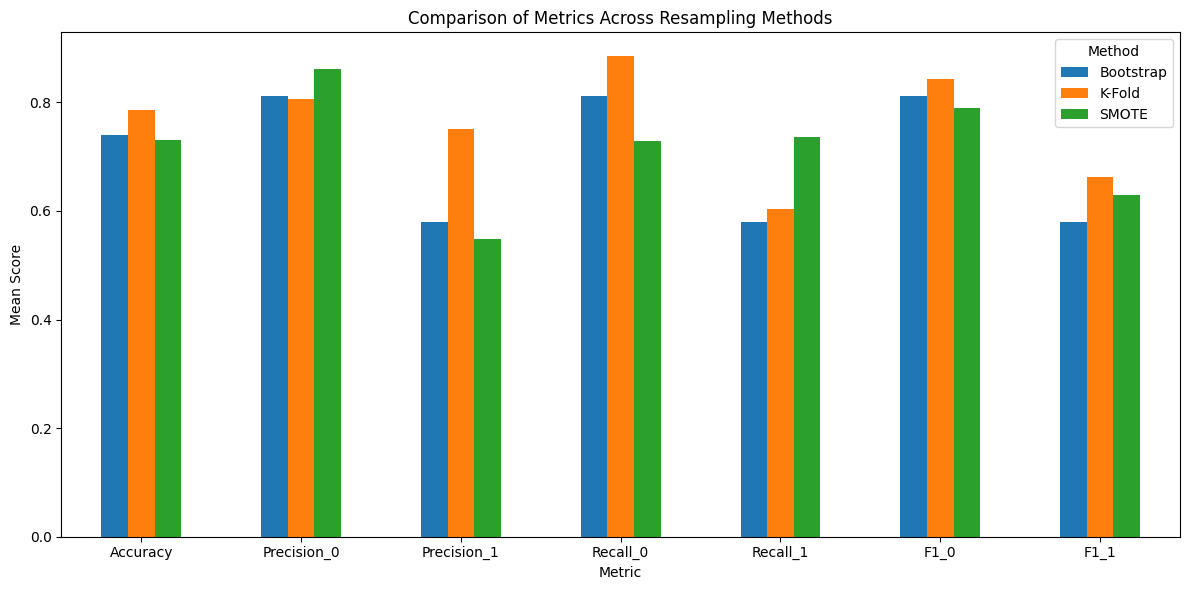

In [ ]:
# Add a new column 'Method' to each DataFrame to identify the technique used
bootstrap_results_df['Method'] = 'Bootstrap'
cv_results_df['Method'] = 'K-Fold'
smote_results_df['Method'] = 'SMOTE'

# Concatenate the three DataFrames into one
all_results_df = pd.concat([bootstrap_results_df, cv_results_df, smote_results_df], ignore_index=True)

# need to drop 'Sample' column from DataFrame
all_results_df = all_results_df.drop(columns=['Sample'], errors='ignore')

# Now calculate the mean values for each metric by 'Method'
mean_results = all_results_df.groupby(['Method']).mean()

# have to transpose so the metrics are on the x-axis labels
mean_results = mean_results.T

# can plot now
plt.figure(figsize=(12, 6))

# use bar plot, have each metric on x-axis and methods as the bars/ in legend
mean_results.plot(kind='bar', figsize=(12, 6))

# Set the plot labels and title
plt.title('Comparison of Metrics Across Resampling Methods')
plt.xlabel('Metric')
plt.ylabel('Mean Score')
plt.xticks(rotation=0)  # No rotation on the x-axis labels for readability
plt.legend(title='Method')

plt.tight_layout()
plt.show()



K-Fold Cross-Validation Results:
   Accuracy  Precision_0  Precision_1  Recall_0  Recall_1      F1_0      F1_1
0  0.741935     0.740000     0.750000     0.925  0.409091  0.822222  0.529412
1  0.790323     0.829268     0.714286     0.850  0.681818  0.839506  0.697674
2  0.822581     0.808511     0.866667     0.950  0.590909  0.873563  0.702703
3  0.725806     0.794872     0.608696     0.775  0.636364  0.784810  0.622222
4  0.819672     0.808511     0.857143     0.950  0.571429  0.873563  0.685714
5  0.819672     0.808511     0.857143     0.950  0.571429  0.873563  0.685714
6  0.770492     0.809524     0.684211     0.850  0.619048  0.829268  0.650000
7  0.786885     0.800000     0.750000     0.900  0.571429  0.847059  0.648649
8  0.819672     0.853659     0.750000     0.875  0.714286  0.864198  0.731707
9  0.721311     0.767442     0.611111     0.825  0.523810  0.795181  0.564103


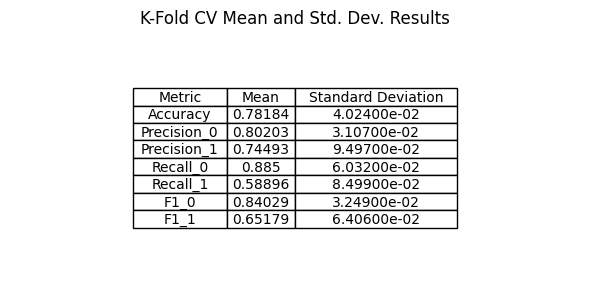


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154

Accuracy: 0.7142857142857143


In [ ]:
# will proceed with K-folds since it outperfomrs the other two methods


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # different Regularization strengths
    'solver': ['lbfgs'],            # use lbfgs solver for optimization
    'max_iter': [200]
}


def k_fold_cross_validation_with_tuning(X, y, num_folds=10, param_grid=None):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    cv_results = []
    best_model = None  # Initialize the var for best model

    # Perform grid search with cross-validation for each fold
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy')

    # Perform cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train)

        # Update best_model with the best model from grid search after each fold
        best_model = grid_search.best_estimator_

        # Get predictions and classification report
        y_pred = best_model.predict(X_val)
        report = classification_report(y_val, y_pred, output_dict=True)

        # Store the results from the report for analysis
        accuracy = report['accuracy']
        precision_0 = report['0']['precision']
        precision_1 = report['1']['precision']
        recall_0 = report['0']['recall']
        recall_1 = report['1']['recall']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        cv_results.append({
            'Accuracy': accuracy,
            'Precision_0': precision_0,
            'Precision_1': precision_1,
            'Recall_0': recall_0,
            'Recall_1': recall_1,
            'F1_0': f1_0,
            'F1_1': f1_1
        })

    return pd.DataFrame(cv_results), best_model  # Return both results and best_model

# Perform k-fold cross-validation with hyperparameter tuning
cv_results_df, best_model = k_fold_cross_validation_with_tuning(X, y, num_folds=10, param_grid=param_grid)

# Print the results
print("K-Fold Cross-Validation Results:")
print(cv_results_df)

# Calculate and print mean and standard deviation for each metric
cv_means = cv_results_df.mean()
cv_std = cv_results_df.std()

# Combine mean and standard deviation into a DataFrame
results_summary = pd.DataFrame({
    'Metric': cv_means.index,
    'Mean': cv_means.round(5).values,
    'Standard Deviation': cv_std.round(5).apply(lambda x: f"{x:.5e}").values  # Scientific notation for small std
})

# Display the mean and std dev in table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the plot
table = ax.table(
    cellText=results_summary.values,
    colLabels=results_summary.columns,
    cellLoc='center',
    loc='center'
)

# Format the table for better visibility
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column widths to reduce white space
table.auto_set_column_width(col=list(range(len(results_summary.columns))))

# Add a title above the table
plt.title("K-Fold CV Mean and Std. Dev. Results", fontsize=12, pad=10)

# Display the plot
plt.tight_layout()
plt.show()

# Now, evaluate the best model on the test set
X_test = test_df_scaled.drop('Outcome', axis=1)  # Make sure test set is processed
y_test = test_df_scaled['Outcome']

# Fit the best model on the whole training data
best_model.fit(X, y)

# Evaluate on the test data
y_pred_test = best_model.predict(X_test)

# Generate and print a classification report for the test set
report_test = classification_report(y_test, y_pred_test)
print("\nTest Set Classification Report:")
print(report_test)

print("Accuracy:", accuracy_score(y_test, y_pred_test))


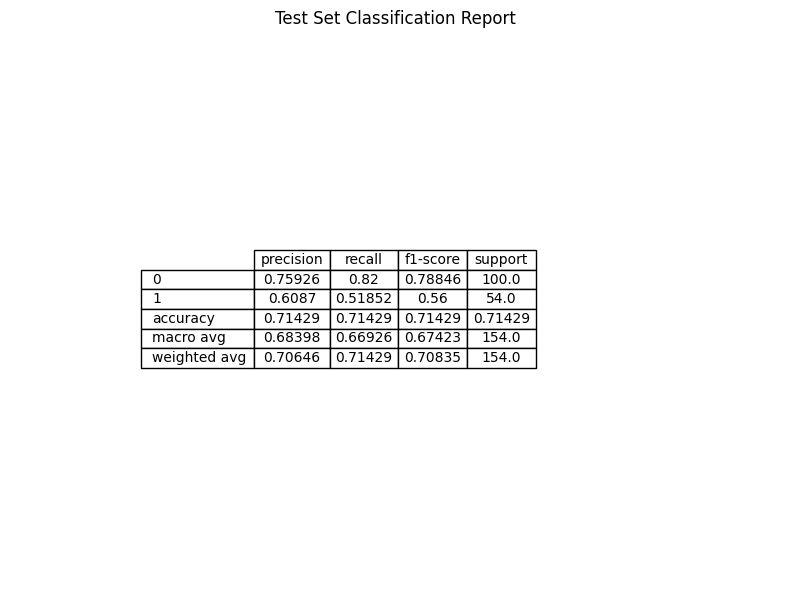

Accuracy: 0.7142857142857143


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # different Regularization strengths
    'solver': ['lbfgs'],            # use lbfgs solver for optimization
    'max_iter': [200]
}

def k_fold_cross_validation_with_tuning(X, y, num_folds=10, param_grid=None):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    best_model = None  # Initialize the var for best model

    # Perform grid search with cross-validation for each fold
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy')

    # Perform cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train)

        # Update best_model with the best model from grid search after each fold
        best_model = grid_search.best_estimator_

        # Get predictions and classification report for validation set
        y_pred = best_model.predict(X_val)
        report = classification_report(y_val, y_pred, output_dict=True)

        # Store results for analysis
        accuracy = report['accuracy']
        precision_0 = report['0']['precision']
        precision_1 = report['1']['precision']
        recall_0 = report['0']['recall']
        recall_1 = report['1']['recall']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

    return best_model  # Return only the best model

# Perform k-fold cross-validation with hyperparameter tuning
best_model = k_fold_cross_validation_with_tuning(X, y, num_folds=10, param_grid=param_grid)

# Now, evaluate the best model on the test set
X_test = test_df_scaled.drop('Outcome', axis=1)  # Make sure test set is processed
y_test = test_df_scaled['Outcome']

# Fit the best model on the whole training data
best_model.fit(X, y)

# Evaluate on the test data
y_pred_test = best_model.predict(X_test)

# Generate and print a classification report for the test set
report_test = classification_report(y_test, y_pred_test, output_dict=True)


# Convert the classification report to a DataFrame for better formatting
report_df = pd.DataFrame(report_test).transpose()

# round it
report_df = report_df.round(5)

# Plot the classification report as a table
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the plot
table = ax.table(cellText=report_df.values,
                colLabels=report_df.columns,
                rowLabels=report_df.index,  # Add row labels (class names)
                cellLoc='center',
                loc='center')

# Format the table for better visibility
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column widths to reduce white space
table.auto_set_column_width(col=list(range(len(report_df.columns))))

plt.title("Test Set Classification Report", fontsize=12, pad=10)
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_test))


In [ ]:
report_test = classification_report(y_test, y_pred_test)

print("\nTest Set Classification Report:")
print(report_test)
print("\n")


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



